<a href="https://colab.research.google.com/github/kharlescim/ERT_Project/blob/main/ERT_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Colab Purpose**
This colab will mainly be used for documenting my thoughts and manipulating the datasets using xarray, as it's easier to quickly visualize and print information from the datasets in this environment. However, training the model on colab takes wayyy too much RAM, enough to crash after just one epoch. As such, training will be done on a different .py file in the repo, although the code will still be written here. For now, all my thoughts and documentation, including on the training done from my machine, will be here. the .py code is just to run the model.

# 7/7 Update <br>
updated cleaning, flattening, and merging of SPEI and LTD datasets so I could train the model on the spei data <br>
the model got a much higher accuracy at .71, but the accuracy plateaued at the very first epoch and no different results were had in the subsequent epochs <br>
also the epochs take over 2 minutes - probably because theres millions of samples to be tested
TODO: <br>
add obs.nc data to model for testing, figure out why accuracy isn't going up

# Analyzing, Cleaning, and Visualizing Datasets (6/27 - 7/3)
In this task, I was asked to clean these datasets, and ensure that they were all in a similar format that we could easily train a model on their combined data.

In [ ]:
!pip install xarray netCDF4

import xarray as xr
import numpy as np
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.1 MB/s eta 0:00:00


In [ ]:
LTD_ds = xr.open_dataset('LTD05.nc')
# USDM05_ds = xr.open_dataset('USDM05_2000_2024.nc')
# obs_ds = xr.open_dataset('obs.nc')
spei_ds = xr.open_dataset('spei_obs_3D.nc')


# LTD and USDM only have one variable, so they can be treated as DataArrays
LTD = LTD_ds['LTD']
# USDM = USDM05_ds['USDM']

**General Knowledge** <br>
General
- Short-Term Drought = less than 6 months
- Long-Term Drought = anything longer

Data Related
- LTD = Long Term Drought (already in USDM format)
- USDM = USDM Rasterdized Data
- obs = VIC Model Drought Index
- spei = SPEI Drought Index

LTD & USDM have weekly temporal frequency, obs and spei are monthly. also obs and spei have multiple variables and should be treated as datasets, while LTD and USDM can simply be treated as dataarrays


In [ ]:
# information about all datasets
'''print(LTD_ds.data_vars)
print(LTD_ds['LTD'].attrs)
print(USDM05_ds.data_vars)
print(USDM05_ds['USDM'].attrs)
print(obs_ds.data_vars)
print(obs_ds['SPI6'].attrs)
print(spei_ds.data_vars)
print(spei_ds['SPEI6'].attrs)'''

Data variables:
    LTD      (time, lat, lon) float32 30MB ...
{}
Data variables:
    USDM     (time, lat, lon) float32 30MB ...
{}
Data variables:
    SPI1     (time, ens, lat, lon) float32 9MB ...
    SPI3     (time, ens, lat, lon) float32 9MB ...
    SPI6     (time, ens, lat, lon) float32 9MB ...
    SPI9     (time, ens, lat, lon) float32 9MB ...
    SPI12    (time, ens, lat, lon) float32 9MB ...
    SPI24    (time, ens, lat, lon) float32 9MB ...
    SPI60    (time, ens, lat, lon) float32 9MB ...
    SMP1     (time, ens, lat, lon) float32 9MB ...
    SMP3     (time, ens, lat, lon) float32 9MB ...
    SMP6     (time, ens, lat, lon) float32 9MB ...
    SMP9     (time, ens, lat, lon) float32 9MB ...
    SMP12    (time, ens, lat, lon) float32 9MB ...
    SMP24    (time, ens, lat, lon) float32 9MB ...
    SMP60    (time, ens, lat, lon) float32 9MB ...
    SRI1     (time, ens, lat, lon) float32 9MB ...
    SRI3     (time, ens, lat, lon) float32 9MB ...
    SRI6     (time, ens, lat, lon) f

In [ ]:
# information on obs + SPEI data for 6 month period
'''print(np.unique(obs_ds['SMP6'].values))
print(np.unique(obs_ds['ens'].values)) #only one ens member, so data can just be treated as time, lat, lon
print(np.unique(spei_ds['SPEI6'].values))'''

[-999.           1.6129031    1.6666667    4.8387094    5.
    8.064516     8.333334    11.290322    11.666667    14.516129
   15.000001    17.741936    18.333334    20.967741    21.666666
   23.333334    24.193548    25.          27.419355    28.333334
   30.645163    31.666666    33.870968    35.          37.096775
   38.333332    40.322582    41.666664    43.548386    45.
   46.774193    48.333332    50.          51.666664    53.22581
   55.          56.451614    58.333332    59.67742     61.666668
   62.903225    65.          66.129036    66.66667     68.333336
   69.354836    70.          71.666664    72.58065     75.
   75.80645     78.333336    79.03226     81.666664    82.258064
   85.          85.48387     88.333336    88.70968     91.66667
   91.935486    95.          95.161285    98.333336    98.3871   ]
[1.]
[-2.0837314  -1.6277134  -1.3722465  -1.1840639  -1.0304712  -0.89799184
 -0.7796601  -0.6713587  -0.57041967 -0.47498992 -0.38370755 -0.2955205
 -0.20957762 -0.1251580

**Data Cleanup TODO** <br>
6/27 <br>
interpolate OBS and SPEI data into monthly data (method = linear)<br>
standardize all datasets using USDM categorical distribution <br>
see how plot animation changes between tasks

7/3 <br>
extract indices from obs/spei for 6+ month ranges, flatten and clean for usage in model

**Interpolating Data**

In [ ]:
# Checking date ranges
'''print(obs_ds.time.values[0])
print(obs_ds.time.values[-1])
print(spei_ds.time.values[0])
print(spei_ds.time.values[-1])
print(LTD_ds.time.values[0])
print(LTD_ds.time.values[-1])
print(USDM05_ds.time.values[0])
print(USDM05_ds.time.values[-1])'''

1991-01-01T00:00:00.000000000
2024-10-01T00:00:00.000000000
1991-01-31T00:00:00.000000000
2024-08-31T00:00:00.000000000
2000-01-04T00:00:00.000000000
2024-12-31T00:00:00.000000000
2000-01-04T00:00:00.000000000
2024-12-31T00:00:00.000000000


In [ ]:
# Creating new time coordinate
weekly_time = LTD_ds.time.values

# Converting to weekly (method = linear)
# obs_weekly = obs_ds.interp(time=weekly_time, method="linear")
spei_weekly = spei_ds.interp(time=weekly_time, method="linear")

**Converting dataset values into Percentiles**

In [ ]:
# Function to convert raw values to percentiles
# missing values = -999 in obs - might need to alter for proper percentile (7-4)
def to_percentile(ds, dim='time', missing_val = -999.0):

    valid = ds.where(ds != missing_val)
    # Convert each grid point's time series to percentile values.
    return valid.rank(dim=dim, pct=True)

# 7/4 IMPORTANT - following is only important for visualization of specific SPEI/OBS dataarrays. NOT HELPFUL for ML model
# Function to bucket entries w/ specific percentiles in matching usdm categories
'''def percentile_to_USDM(p):
  return xr.where(p.isnull(), np.nan,         # -1 for NaN values  (7/4)
           xr.where( p <= 0.02, 4,        # D4 (Exceptional Drought) = .00-.02
           xr.where(p <= 0.05, 3,         # D3 (Extreme Drought) = .02-.05
           xr.where(p <= 0.10, 2,         # D2 (Severe Drought) = .05-.10
           xr.where(p <= 0.20, 1,
          xr.where(p <= 0.3, 0, -1))))))   # D1 (Moderate Drought) = .1-.2, else D0 (Abnormally Dry)'''


# percentiles_obs = to_percentile(obs_weekly)
# USDM_obs = percentile_to_USDM(percentiles_obs)
percentiles_spei = to_percentile(spei_weekly)
# USDM_spei = percentile_to_USDM(percentiles_spei)

In [ ]:
print(np.unique(percentiles_obs['SPI6'].values))
print(np.unique(percentiles_obs['SMP6'].values))

[7.73993808e-04 1.54798762e-03 1.93498452e-03 ... 9.99226006e-01
 1.00000000e+00            nan]
[7.73993808e-04 1.16099071e-03 1.54798762e-03 ... 9.99613003e-01
 1.00000000e+00            nan]


**Flattening datasets**

for now, just merging spei and LTD only for testing

In [ ]:
# ens = 1, so safe to ignore it from dataset
# testing flattening out entire dataset
# flat_obs = percentiles_obs.to_dataframe()
spei_df = percentiles_spei.to_dataframe().reset_index()
print(spei_df.head(10))

        time    lat     lon  SPEI1  SPEI3  SPEI6  SPEI12  SPEI24  SPEI60  \
0 2000-01-04  25.25 -125.75    NaN    NaN    NaN     NaN     NaN     NaN   
1 2000-01-04  25.25 -125.25    NaN    NaN    NaN     NaN     NaN     NaN   
2 2000-01-04  25.25 -124.75    NaN    NaN    NaN     NaN     NaN     NaN   
3 2000-01-04  25.25 -124.25    NaN    NaN    NaN     NaN     NaN     NaN   
4 2000-01-04  25.25 -123.75    NaN    NaN    NaN     NaN     NaN     NaN   
5 2000-01-04  25.25 -123.25    NaN    NaN    NaN     NaN     NaN     NaN   
6 2000-01-04  25.25 -122.75    NaN    NaN    NaN     NaN     NaN     NaN   
7 2000-01-04  25.25 -122.25    NaN    NaN    NaN     NaN     NaN     NaN   
8 2000-01-04  25.25 -121.75    NaN    NaN    NaN     NaN     NaN     NaN   
9 2000-01-04  25.25 -121.25    NaN    NaN    NaN     NaN     NaN     NaN   

   SPEI2  SPEI9  SPEI36  SPEI48  SPEI72  
0    NaN    NaN     NaN     NaN     NaN  
1    NaN    NaN     NaN     NaN     NaN  
2    NaN    NaN     NaN     NaN     N

converting and cleaning LTD to dataframe <br>
**Important:** changing datetime to Unix epoch format for use with TensorFlow
- may want to later extract month + day values. for now this is what we got

also changing LTD to be int

In [ ]:
LTD_df = LTD.to_dataframe().reset_index()
print(LTD_df.head(10))

        time    lat     lon  LTD
0 2000-01-04  25.25 -125.75  NaN
1 2000-01-04  25.25 -125.25  NaN
2 2000-01-04  25.25 -124.75  NaN
3 2000-01-04  25.25 -124.25  NaN
4 2000-01-04  25.25 -123.75  NaN
5 2000-01-04  25.25 -123.25  NaN
6 2000-01-04  25.25 -122.75  NaN
7 2000-01-04  25.25 -122.25  NaN
8 2000-01-04  25.25 -121.75  NaN
9 2000-01-04  25.25 -121.25  NaN


In [ ]:
merged_df = pd.merge(spei_df, LTD_df, on=['time', 'lat', 'lon'], how='inner')
print(merged_df.head(10))

        time    lat     lon  SPEI1  SPEI3  SPEI6  SPEI12  SPEI24  SPEI60  \
0 2000-01-04  25.25 -125.75    NaN    NaN    NaN     NaN     NaN     NaN   
1 2000-01-04  25.25 -125.25    NaN    NaN    NaN     NaN     NaN     NaN   
2 2000-01-04  25.25 -124.75    NaN    NaN    NaN     NaN     NaN     NaN   
3 2000-01-04  25.25 -124.25    NaN    NaN    NaN     NaN     NaN     NaN   
4 2000-01-04  25.25 -123.75    NaN    NaN    NaN     NaN     NaN     NaN   
5 2000-01-04  25.25 -123.25    NaN    NaN    NaN     NaN     NaN     NaN   
6 2000-01-04  25.25 -122.75    NaN    NaN    NaN     NaN     NaN     NaN   
7 2000-01-04  25.25 -122.25    NaN    NaN    NaN     NaN     NaN     NaN   
8 2000-01-04  25.25 -121.75    NaN    NaN    NaN     NaN     NaN     NaN   
9 2000-01-04  25.25 -121.25    NaN    NaN    NaN     NaN     NaN     NaN   

   SPEI2  SPEI9  SPEI36  SPEI48  SPEI72  LTD  
0    NaN    NaN     NaN     NaN     NaN  NaN  
1    NaN    NaN     NaN     NaN     NaN  NaN  
2    NaN    NaN     Na

In [ ]:
# cleaning up NaN entries
df = merged_df.dropna(subset=['LTD']).copy()

# changing -1 classification to 5 to work with featurespace
df["LTD"] = df["LTD"].replace(-1, 5)


# changing datetime to be usable by TensorFlow, changing LTD from float to int to match example
df["time"] = pd.to_datetime(df["time"]).map(pd.Timestamp.timestamp)
df.head() # LTD is target

,time,lat,lon,SPEI1,SPEI3,SPEI6,SPEI12,SPEI24,SPEI60,SPEI2,SPEI9,SPEI36,SPEI48,SPEI72,LTD
89,946944000.0,25.25,-81.25,0.453674,0.856230,0.892971,0.937700,0.944089,0.966454,0.444089,0.950479,0.987220,0.979233,0.920128,-1.0
90,946944000.0,25.25,-80.75,0.565657,0.977467,0.984848,0.882673,0.825952,0.991841,0.505051,0.923854,0.968143,0.950272,0.986791,-1.0
91,946944000.0,25.25,-80.25,0.269968,0.833866,0.806709,0.514377,0.654952,0.937700,0.421725,0.555911,0.955272,0.897764,0.944089,-1.0
207,946944000.0,25.75,-81.25,0.281274,0.936286,1.000000,0.990676,0.997280,0.999223,0.612277,0.989510,0.993395,0.983683,0.986791,-1.0
208,946944000.0,25.75,-80.75,0.419580,0.969697,0.993395,0.969697,0.955322,1.000000,0.418415,0.986014,0.951049,0.975136,0.998834,-1.0


##7/5 stop here##

flattened and combined spei and obs into one dataframe
time, lat, lon are still multi-index. might need to change that for ML model? <br>
percentiles and entries should all be correct, combined df is stored as output.csv on my machine <br>
actual hell trying to get to that point, colab kept crashing. prob need to switch to vscode <br>
TODO: <br>
redo combined dataframe, dropping time, lat, and lon before resetting index instead of using multiindex (keras isn't prepped for multiindex)
drop NaN rows

## 7/7

took a step back and just merged spei and LTD - time, lat, and lon are now normal features instead of multi-index
all lat/lon/time entries match between spei and LTD - no unique values, so merging was easy
all percentiles, NaN values, and df should be correct
now tryna test model before adding obs

# Training an MI Model using Keras <br>
For now, we'll train the model following the basic examples using the utilities given by Keras, such as FeatureSpace. Later if needed, we can try implementing the model from scratch to better manage parameters

Possible examples from Keras: <br>
- **Structured Data Classification using FeatureSpace**
  - predict USDM drought class from lat/lon/time
- Timeseries Classification (pdf notes that these are potentially valuable, but weren't particularly studied)
  - predict future LTD values from past LTD datasets/values




### Model using only LTD data (6/27 - 7/3)
This week, I was tasked with training the model on just the Long-Term Drought (LTD) dataset, just as a starter. The LTD dataset only has data on longitude, latitude, and time. As such, while it is useful to record and visualize the data, it isn't suitable for training the model to consistently predict drought classifications. Later, we will incorporate other datasets, such as the SPEI drought index and VIC model drought index, which will have more helpful information to improve accuracy


importing relevant keras stuff

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras.utils import FeatureSpace

**Applying Keras Structured Data Classification w/ Feature Space to cleaned LTD dataframe**

splitting data into training + validation set

In [ ]:
val_df = df.sample(frac=0.2, random_state=1337)
train_df = df.drop(val_df.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_df), len(val_df))
)

Using 3544380 samples for training and 886095 for validation


Generating tf.data.Dataset for each dataframe, where each Dataset yields a tuple (input, target). <br>
Input is a dictionary of features, target (LTD) is a value 0-4 <br>

In [ ]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("LTD")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_df)
val_ds = dataframe_to_dataset(val_df)

for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Batching Datasets

In [ ]:
train_ds = train_ds.batch(16)
val_ds = val_ds.batch(16)

Configuring our FeatureSpace
- for now, features are pretty barebones. just as they are in original dataframe

In [ ]:
feature_space = FeatureSpace(
    features={
        "lat": "float",
        "lon": "float",
        "time": "float",
        "SPEI1" : "float",
        "SPEI3" : "float",
        "SPEI6" : "float",
        "SPEI12" : "float",
        "SPEI24" : "float",
        "SPEI60" : "float",
        "SPEI2" : "float",
        "SPEI9" : "float",
        "SPEI36" : "float",
        "SPEI48" : "float",
        "SPEI72" : "float",

    },
    output_mode="concat"
)

Adapting FeatureSpace to training data

In [ ]:
train_ds_with_no_labels = train_ds.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

for x, _ in train_ds.take(1):
    preprocessed_x = feature_space(x)
    print("preprocessed_x.shape:", preprocessed_x.shape)
    print("preprocessed_x.dtype:", preprocessed_x.dtype)

preprocessed_x.shape: (16, 3)
preprocessed_x.dtype: <dtype: 'float32'>


Manage preprocessing in tf.data pipeline

In [ ]:
preprocessed_train_ds = train_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_train_ds = preprocessed_train_ds.prefetch(tf.data.AUTOTUNE)

preprocessed_val_ds = val_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_val_ds = preprocessed_val_ds.prefetch(tf.data.AUTOTUNE)

**Build training & Inference Model**

Loss function - using sparse_categorical_crossentropy instead of binary_classification, since the target label ranges from 0-4 instead of binary values

Similarly, modified keras.Layers.Dense to have 5 output nodes instead of 2


In [ ]:
dict_inputs = feature_space.get_inputs()
encoded_features = feature_space.get_encoded_features()

x = keras.layers.Dense(32, activation="relu")(encoded_features)
x = keras.layers.Dropout(0.5)(x)
# change from example in order to fit categorization of LTD
predictions = keras.layers.Dense(6, activation="softmax")(x)

training_model = keras.Model(inputs=encoded_features, outputs=predictions)
training_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"] # change this too to from binary
)

inference_model = keras.Model(inputs=dict_inputs, outputs=predictions)

Train Model for 20 Epochs

From tests on my own machine, accuracy plateaus at 0.2678 at the second or third epoch, indicating that while the model is more accurate than pure random (1/5 chance), it suffers from underfitting/not being able to discern enough information well enough to predict correctly past a certain threshold. While this could be attributed to how the model was trained, I think it's more likely because it was only trained on the features given by LTD, which were lat, lon, and timezone (converted into Unix Epoch to account for TensorFlow) - not really good indicators for when a drought would come. I think the model would need to be trained on the other .nc files to be more accurate, but it could still be an issue with how I trained the model. need to ask.

In [ ]:
training_model.fit(
    preprocessed_train_ds,
    epochs=20,
    validation_data=preprocessed_val_ds,
    verbose=2,
)

### Incorporating SPEI into Model

turns out LTD is the target, and each SPEI variable for each datetime is the input. that explains a lot

**Visualizing Datasets w/ Animation**

to be used to animate USDM datasets

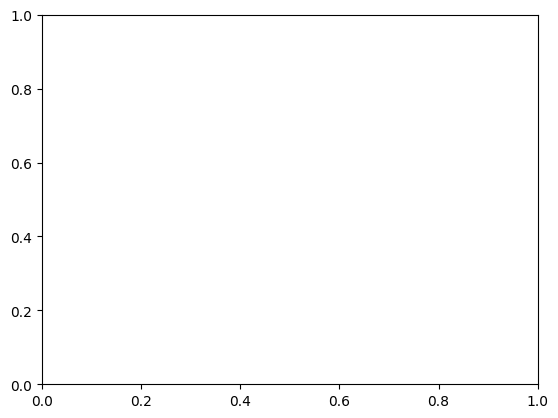

In [ ]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

# Define the update function
def animate(data, i):
    ax.clear()
    # Store the plot object
    plot_obj = data.isel(time=i).plot(ax=ax, add_colorbar=False)
    ax.set_title(str(data.time[i].values)[:10])
    # Return the plot object
    return plot_obj


In [ ]:
# 7/4 - These animations are only useful for plotting data directly from
# plotting raw LTD dataset (LTD is already in USDM range)
anim_LTD = animation.FuncAnimation(fig, lambda i: animate(LTD, i), frames=len(LTD.time), interval=100)
HTML(anim_LTD.to_html5_video())

# plotting singular spei dataset, post USDM conversion
anim_spei = animation.FuncAnimation(fig, lambda i: animate(USDM_spei["SPEI6"], i), frames=len(USDM_spei.time), interval=100)
HTML(anim_spei.to_html5_video())

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-framerate', '10.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpzwagqaru/temp.m4v']' returned non-zero exit status 255.